<a href="https://colab.research.google.com/github/goerlitz/nlp-classification/blob/main/notebooks/10kGNAD/colab/21d_10kGNAD_optuna_trial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Optuna Studies and Trials

Aggregates and displays studies and trials found in a optuna database 

**Overview of all Studies**
* trial states and hyperparam distribution settings
* visualization of best trials

**Study Details**
* parallel plot of hyperparameters
* hyperparameter importance
* evaluation metrics plots
* training progress

In [1]:
!pip install -q --upgrade optuna >/dev/null

In [2]:
import pandas as pd
import optuna
import matplotlib.pyplot as plt

## Connect Google Drive

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Database Connection

In [4]:
db_path = "/content/gdrive/My Drive/Colab Notebooks/nlp-classification/"
db_name = "10kgnad_optuna"
storage = f"sqlite:///{db_path}{db_name}.db"

## Study Information

In [5]:
from optuna.storages import RDBStorage
from optuna.trial import TrialState
import matplotlib as mpl
import numpy as np

# adjust style
mpl.style.use("seaborn-notebook")
mpl.rcParams["figure.figsize"] = (6,4)
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["axes.grid"] = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['patch.linewidth'] = 1.0  # also affects legend border


class StudyInfo:

    def __init__(self, storage: str):
        self.storage = RDBStorage(url=storage)
        self._trials_df = None

    def dist2str(self, dist: optuna.distributions.BaseDistribution) -> str:
        """Create string representation for parameter distributions."""
        if isinstance(dist, optuna.distributions.UniformDistribution):
            return f"{dist.low} -> {dist.high}"
        if isinstance(dist, optuna.distributions.LogUniformDistribution):
            return f"{dist.low} -> {dist.high} (log)"
        if isinstance(dist, optuna.distributions.CategoricalDistribution):
            return f"{list(dist.choices)}"
        else:
            return str(dist)
    
    def study_details(self) ->pd.DataFrame:

        study_info = []
        study_states = []
        study_dist = []

        for s in optuna.get_all_study_summaries(storage):
            name = s.study_name
            info = {"study_name": name,
                    "start": "???" if s.datetime_start is None else s.datetime_start.date(),
                    "directions": len(s.directions)}
            study_info.append(info)

            study = optuna.load_study(name, storage)
            states = pd.Series([t.state for t in study.get_trials()]).value_counts()
            counts = {str(state).split(".")[1]:count for state, count in states.items()}
            study_states.append(counts)

            dist = study.get_trials()[0].distributions
            dist = {k:self.dist2str(dist[k]) for k in dist.keys()}
            study_dist.append(dist)

        return (pd.concat([pd.DataFrame(study_info),
                           pd.DataFrame(study_states).fillna(0).astype(int),
                           pd.DataFrame(study_dist)
                          ], axis=1).
                fillna("--").
                set_index("study_name").
                sort_values("study_name")
                )
    
    def _colors(self, pal: "ColorMap", n=10):
        """Create a list of n colors using the given colormap."""
        norm = mpl.colors.Normalize(vmin=0, vmax=n-1)
        return [pal(norm(i)) for i in range(0,n)]

    def show_best_trials(self, metrics=["eval_loss", "eval_f1"], figsize=None):
        """Visualization of best trials from all studies."""

        best_trials = []
        for s in optuna.get_all_study_summaries(self.storage):
            best_trials.append(self.get_best_trials(s.study_name).
                               assign(study_name=s.study_name))
        best_trials_df = pd.concat(best_trials)

        title = "Performance of Best Study Trials"

        n=20
        fig, ax = plt.subplots(figsize=figsize)
        pal = self._colors(mpl.cm.tab20, n)

        for i, s in enumerate(sorted(best_trials_df.study_name.unique())):
            df = best_trials_df[lambda x: x["study_name"] == s]
            ax.scatter(df[metrics[0]], df[metrics[1]], label=s, color=pal[i%n])
        
        ax.grid(axis='y', linestyle='--', zorder=0)
        ax.grid(axis='x', linestyle=':', zorder=0)


        # ax = plt.gca()
        # ax.add_patch(Ellipse(xy=(0.371, 0.877), width=0.01, height=0.02, edgecolor='gray', fc='None', lw=1.5))
        # ax.add_patch(Ellipse(xy=(0.372, 0.904), width=0.01, height=0.015, edgecolor='gray', fc='None', lw=1.5))

        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        ax.set_xlabel(metrics[0])
        ax.set_ylabel(metrics[1])
        ax.set_title(title)

        fig.tight_layout()
        return fig

    def _extract_metrics(self, t: optuna.Trial):
        """extract metrics stored in user attributes."""

        attrs = t.user_attrs
        # handle older format
        if "eval_result" in attrs.keys():
            attrs = attrs["eval_result"]
        attrs = {k:attrs[k] for k in attrs if k != "epoch"}
        return attrs

    def _trials2df(self, trials: "List[optuna.Trial]") -> pd.DataFrame:
        """Convert list of trials into a DataFrame."""

        index = [t.number for t in trials]
        params = [t.params for t in trials]
        metrics = [self._extract_metrics(t) for t in trials]
        starts = [{"start":t.datetime_start.date()} for t in trials]

        dfs = [pd.DataFrame(d, index=index) for d in [starts, metrics, params]]
        map = {"num_train_epochs": "epochs",
            "per_device_train_batch_size": "bs"}
        
        trials_df = (pd.concat(dfs, axis=1).
                     rename(columns=map).
                     sort_values("eval_loss"))
        return trials_df

    def get_best_trials(self, study_name, sort_by="eval_loss", ascending=True) -> pd.DataFrame:

        # TODO cache study for repeated use
        study = optuna.load_study(study_name, self.storage)
        trials = study.best_trials
        return self._trials2df(trials).sort_values(sort_by, ascending=ascending)

    def get_trials(self, study_name: str, states=[TrialState.COMPLETE]) -> pd.DataFrame:

        # TODO caching of study and processed trials
        # if self.study_trials is None or not self.study_trials.match(study_name, states):
        #     self.study_trials = StudyTrials.load(study_name, states, self.storage)
        # return self.study_trials.trial_df

        study = optuna.load_study(study_name, self.storage)
        trials = study.get_trials(states=states)
        trials_df = self._trials2df(trials)
        return trials_df

    
    def plot_lr_metrics(self, study_name: str, group_by = "bs", metrics = ["eval_loss", "eval_f1"], figsize=None):

        fig, axs = plt.subplots(len(metrics), 1, figsize=figsize, sharex=True)
        pal = self._colors(mpl.cm.tab10, 10)
        limits = {"eval_loss": (0.3, 0.6),
                  "eval_f1": (0.85, 0.92)}
        
        trial_df = self.get_trials(study_name)

        for m, ax in zip(metrics, axs):
            for i, g in enumerate(sorted(trial_df[group_by].unique())):
                df = trial_df[lambda x: x[group_by] == g]
                ax.scatter(df.learning_rate, df[m], alpha=0.6, s=16, label=g, color=pal[i])
                ax.set_xscale('log')
                ax.set_ylabel(m)
                ax.grid(axis='y', linestyle='--', zorder=1)
                ax.grid(axis='x', linestyle=':', zorder=1)
                ax.legend(title=group_by)
                if m in limits:
                    ax.set_ylim(limits[m])

        ax.set_xlabel("learning rate")
        fig.suptitle(f"{study_name} ({trial_df.shape[0]} trials)")
        fig.tight_layout()
        fig.subplots_adjust(top=0.92)
        return fig

    def plot_lr_metrics2(self, study_names: "List[str]", group_by = "bs", metrics = ["eval_loss", "eval_f1"], figsize=None):

        num_metrics = len(metrics)
        num_studies = len(study_names)
        
        # plt.style.use('default')
        fig, axs = plt.subplots(num_metrics, num_studies, figsize=figsize, sharex=True)
        axs = axs.flatten()

        pal = self._colors(mpl.cm.tab10, 10)
        limits = {"eval_loss": (0.3, 0.7),
                  "eval_f1": (0.85, 0.92)}

        for k, s in enumerate(study_names):
            trial_df = self.get_trials(s)
            categories = trial_df[group_by].unique()

            for j, m in enumerate(metrics):
                ax = axs[j*num_studies+k]

                for i, g in enumerate(sorted(trial_df[group_by].unique())):
                    df = trial_df[lambda x: x[group_by] == g]
                    ax.scatter(df.learning_rate, df[m], alpha=0.6, s=16, label=g, color=pal[i], zorder=2)
                
                ax.set_xscale('log')
                ax.set_ylabel(m)

                ax.grid(axis='y', linestyle='--', zorder=0)
                ax.grid(axis='x', linestyle=':', zorder=0)
                ax.grid(True, which="both")

                # l = ax.legend(ncol=len(categories), title=group_by)
                l = ax.legend(ncol=len(categories))
                # l.get_title().set_position((-10, 0))

                if m in limits:
                    ax.set_ylim(limits[m])

                if j == num_metrics - 1:
                    ax.set_xlabel("learning rate")
                if j == 0:
                    ax.set_title(f"{s} ({trial_df.shape[0]} trials)", size=10)
        fig.tight_layout()
        fig.subplots_adjust(top=0.92)
        return fig
    
    def show_trial_metrics(self, study_name, figsize=None):

        fig, axs = plt.subplots(2, 3, figsize=figsize, sharex=True, sharey=True)

        trial_df = self.get_trials(study_name)
        best = self.get_best_trials(study_name).index.values
        trial_df["best"] = trial_df.index.isin(best)

        exclude = ["eval_runtime", "eval_samples_per_second", "eval_steps_per_second"]
        metrics = [m for m in trial_df.columns if m.startswith("eval_") and m not in exclude]

        # only focus on low loss trials
        loss_df = trial_df[lambda x: x.eval_loss < x.eval_loss.mean()]

        for col, ax in zip(metrics[1:], axs.flat):
            if col == "eval_loss":
                continue
            ax.scatter(loss_df.eval_loss, loss_df[col], c=loss_df.best, cmap="Set1_r", alpha=0.6, s=8);
            ax.set_title(col)
            ax.set_xlabel("eval loss")
            ax.grid(axis='y', linestyle='--', zorder=1)
            ax.grid(axis='x', linestyle=':', zorder=1)
            ax.xaxis.set_tick_params(labelbottom=True)

        axs.flat[-1].axis('off')
        fig.tight_layout()
        fig.suptitle(study_name)
        fig.subplots_adjust(top=0.90)
    
    def plot_param_dist(self, study_name, figsize=None):
        """Show distribution of parameter selection"""
        trials_df = self.get_trials(study_name).drop("start", axis=1)
        columns = [c for c in trials_df.columns if not c.startswith("eval_")]

        fig, axs = plt.subplots(1, len(columns), figsize=figsize)

        for c, ax in zip(columns, axs.flat):
            s = trials_df[c]
            ax.set_title(c)
            if s.dtype == 'int64':
                counts = s.value_counts().sort_index()
                counts.plot.bar(ax=ax)
            elif s.dtype == 'float64':
                bins = np.logspace(np.log10(min(s)),np.log10(max(s)), 50)
                s.plot.hist(ax=ax, bins=bins)
                ax.set_xscale("log")
                ax.set_ylabel(None)
                ax.grid(True, which="both")
        fig.tight_layout()
        fig.suptitle(study_name)
        fig.subplots_adjust(top=0.80)
    
    def get_trial_logs(self, study_name):
        study = optuna.load_study(study_name, self.storage)
        trials = study.get_trials(states=[TrialState.COMPLETE])
        return trials

    def extract_trial_logs(self, trial):
        attrs = trial.user_attrs
        attrs = {k:attrs[k] for k in attrs if k != "eval_result"}
        log_df = pd.DataFrame(attrs.values(), index=[int(k) for k in attrs.keys()]).sort_index()
        return log_df

    def plot_training_steps(self, study_name, figsize=None):
        trials = self.get_trial_logs(study_name)
        lrs = [t.params["learning_rate"] for t in trials]
        batch_sizes = sorted(set([t.params["per_device_train_batch_size"] for t in trials]))

        # best trial loss
        min_loss = info.get_best_trials(study_name).sort_values("eval_loss")["eval_loss"].values[0]

        fig, axs = plt.subplots(2, 3, figsize=figsize, sharex=False, sharey=True)

        norm = mpl.colors.LogNorm(vmin=min(lrs), vmax=max(lrs))
        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.brg) # cool

        for bs, ax in zip(batch_sizes, axs.flat):
            bs_trials = [t for t in trials if t.params["per_device_train_batch_size"] == bs]
            ax.set_title(f"bs={bs}")
            ax.set_xlabel("steps")
            ax.set_ylabel("loss")
            ax.axhline(y=min_loss, color="0.8", linestyle=':')
            for t in bs_trials:
                if not "eval_result" in t.user_attrs.keys():
                    continue
                lr = t.params["learning_rate"]
                log_df = self.extract_trial_logs(t)
                ax.plot(log_df["eval_loss"][:-1], c=cmap.to_rgba(lr), alpha=0.5)
        
        axs.flat[-1].axis('off')
        plt.ylim([None,0.6])

        fig.suptitle(f"Training steps of '{study_name}' ({len(trials)} trials)")
        fig.tight_layout()
        fig.subplots_adjust(top=0.9, right=0.92)
        cb = fig.colorbar(cmap, ax=axs, shrink=0.6, location='right')
        cb.set_label('learning rate')

# Get Overview of all Studies

In [6]:
info = StudyInfo(storage)

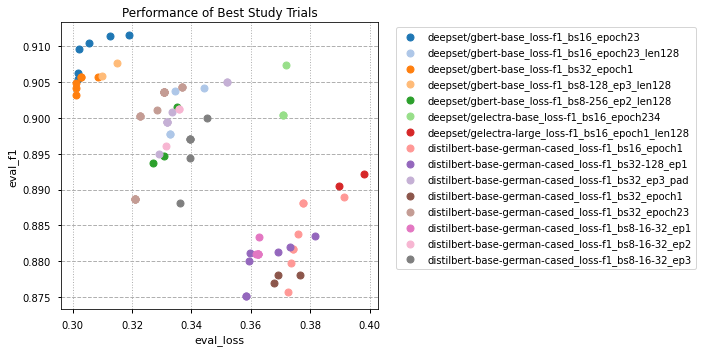

In [7]:
info.show_best_trials(figsize=(10,5));

In [8]:
info.study_details()

,start,directions,COMPLETE,RUNNING,FAIL,PRUNED,WAITING,learning_rate,num_train_epochs,per_device_train_batch_size,weight_decay
study_name,,,,,,,,,,,
deepset/gbert-base_loss-f1_bs16_epoch23,2022-01-09,2,36,2,1,126,0,1e-05 -> 0.0001 (log),"[2, 3]",[16],0.001 -> 0.01 (log)
deepset/gbert-base_loss-f1_bs16_epoch23_len128,2022-01-11,2,145,3,0,0,0,1e-05 -> 0.0001 (log),"[2, 3]",[16],0.001 -> 0.01 (log)
deepset/gbert-base_loss-f1_bs32_epoch1,2022-01-08,2,63,2,3,27,0,3e-05 -> 0.0001 (log),[1],[16],0.001 -> 0.01 (log)
deepset/gbert-base_loss-f1_bs8-128_ep3_len128,2022-01-23,2,290,1,2,0,0,7e-06 -> 0.0002 (log),[3],"[8, 16, 32, 64, 128]",0.001 -> 0.01 (log)
deepset/gbert-base_loss-f1_bs8-256_ep2_len128,2022-01-25,2,111,1,0,0,0,5e-06 -> 0.0005 (log),[2],"[8, 16, 32, 64, 128, 256]",0.001 -> 0.01 (log)
deepset/gelectra-base_loss-f1_bs16_epoch234,2022-01-01,2,141,6,2,0,0,6e-05 -> 0.0002 (log),"[2, 3]",[16],0.001 -> 0.01 (log)
deepset/gelectra-large_loss-f1_bs16_epoch1_len128,2022-01-12,2,41,2,0,0,0,1e-05 -> 0.0001 (log),[1],[16],0.001 -> 0.01 (log)
distilbert-base-german-cased_loss-f1_bs16_epoch1,2022-01-13,2,190,1,1,0,0,4e-05 -> 0.0004 (log),[1],[16],0.001 -> 0.01 (log)
distilbert-base-german-cased_loss-f1_bs32-128_ep1,2022-01-18,2,223,5,1,0,0,1e-05 -> 0.0004 (log),[1],"[32, 64, 128]",0.001 -> 0.01 (log)


## Investigate a Study in Details

In [9]:
# study = "distilbert-base-german-cased_loss-f1_bs32-128_ep1"
study = "distilbert-base-german-cased_loss-f1_bs8-16-32_ep2"
# study = "distilbert-base-german-cased_loss-f1_bs32_epoch23"
# study = "deepset/gbert-base_loss-f1_bs16_epoch23_len128"

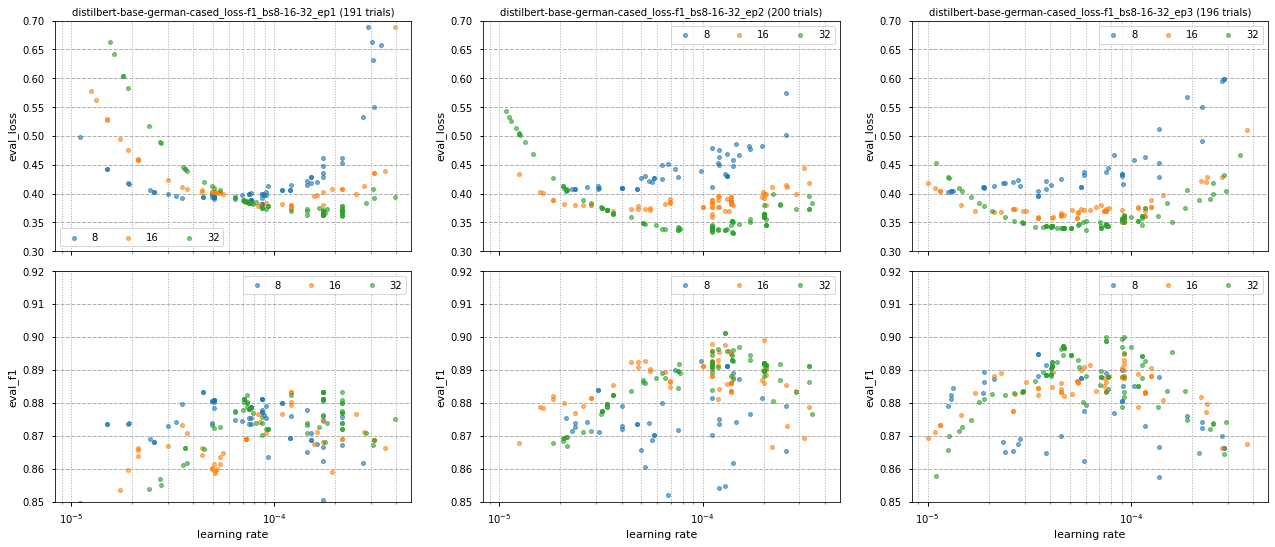

In [10]:
info.plot_lr_metrics2(["distilbert-base-german-cased_loss-f1_bs8-16-32_ep1",
                       "distilbert-base-german-cased_loss-f1_bs8-16-32_ep2",
                       "distilbert-base-german-cased_loss-f1_bs8-16-32_ep3"],
                      group_by="bs", figsize=(18,8));

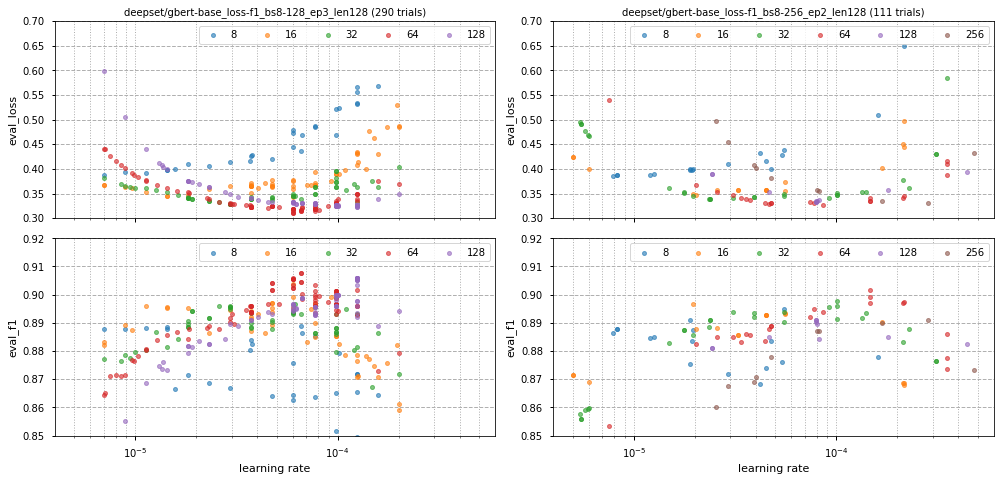

In [11]:
info.plot_lr_metrics2(["deepset/gbert-base_loss-f1_bs8-128_ep3_len128",
                       "deepset/gbert-base_loss-f1_bs8-256_ep2_len128"], group_by="bs", figsize=(14,7));

In [12]:
display(info.get_best_trials("deepset/gbert-base_loss-f1_bs8-128_ep3_len128"))
display(info.get_best_trials("deepset/gbert-base_loss-f1_bs8-256_ep2_len128"))

,start,eval_loss,eval_acc,eval_f1,eval_precision,eval_recall,eval_mcc,eval_runtime,eval_samples_per_second,eval_steps_per_second,learning_rate,epochs,bs,weight_decay
54,2022-01-23,0.309711,0.909533,0.905857,0.905773,0.906911,0.896490,5.1346,200.212,25.124,0.000060,3,64,0.001069
264,2022-01-25,0.314870,0.910506,0.907684,0.906755,0.909598,0.897623,4.9542,207.503,26.039,0.000065,3,64,0.001339


,start,eval_loss,eval_acc,eval_f1,eval_precision,eval_recall,eval_mcc,eval_runtime,eval_samples_per_second,eval_steps_per_second,learning_rate,epochs,bs,weight_decay
98,2022-01-26,0.327143,0.900778,0.893787,0.893788,0.895930,0.886505,5.1763,198.598,24.921,0.000086,2,64,0.002484
92,2022-01-26,0.330808,0.900778,0.894766,0.893724,0.897881,0.886517,5.1690,198.879,24.957,0.000077,2,64,0.001094
85,2022-01-26,0.335222,0.904669,0.901520,0.898533,0.905863,0.890966,4.9754,206.617,25.928,0.000146,2,64,0.002328


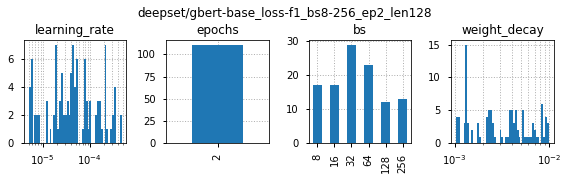

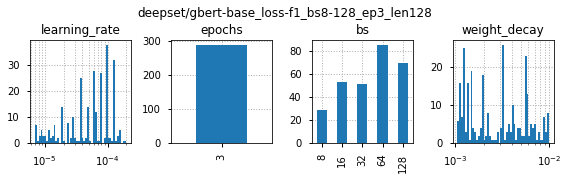

In [13]:
info.plot_param_dist("deepset/gbert-base_loss-f1_bs8-256_ep2_len128", figsize=(8,2.5))
info.plot_param_dist("deepset/gbert-base_loss-f1_bs8-128_ep3_len128", figsize=(8,2.5))

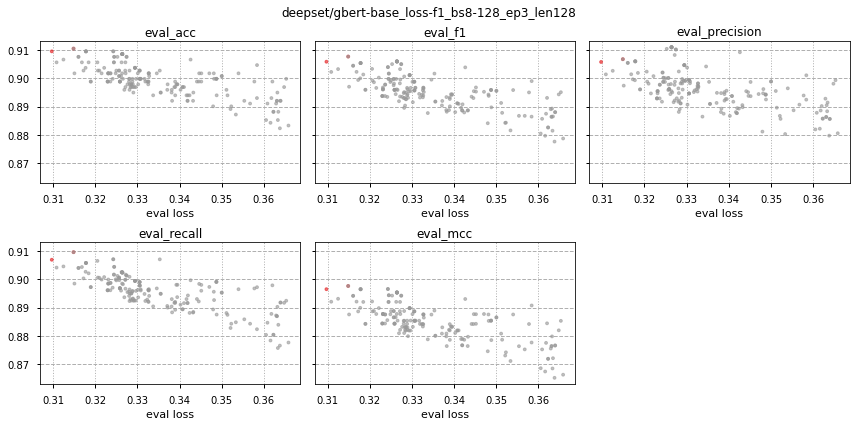

In [14]:
info.show_trial_metrics("deepset/gbert-base_loss-f1_bs8-128_ep3_len128", figsize=(12,6))

## Learning Curves

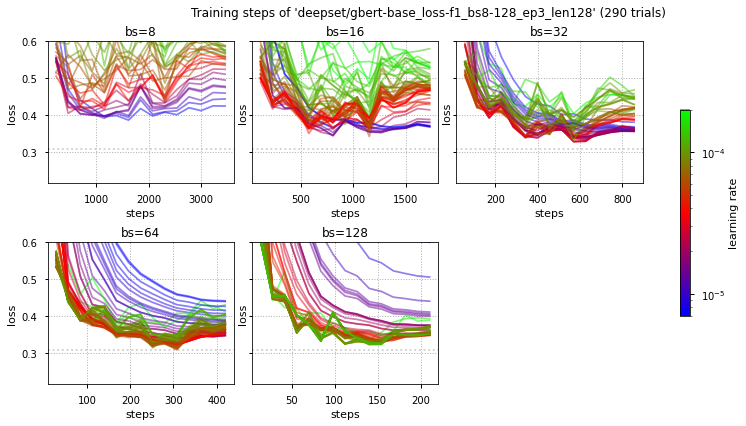

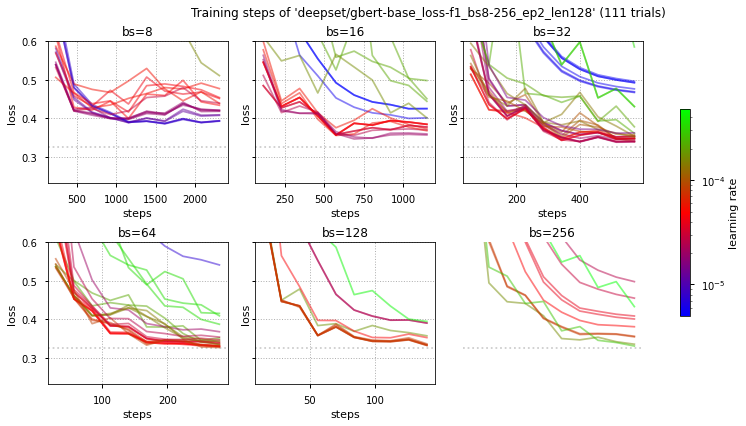

In [15]:
info.plot_training_steps("deepset/gbert-base_loss-f1_bs8-128_ep3_len128", figsize=(12,6))
info.plot_training_steps("deepset/gbert-base_loss-f1_bs8-256_ep2_len128", figsize=(12,6))

---
## Generate Testing Sequences

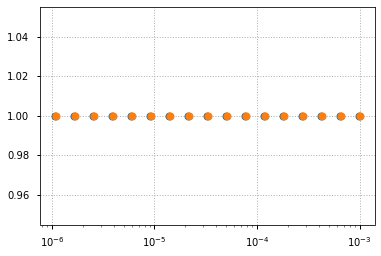

In [16]:
import random
import numpy as np

def test_lr(start: float, end: float, n, log=True):

    if log:
        middle = np.exp((np.log(start) + np.log(end)) / 2)
    else:
        middle = (start + end) / 2
    
    if n == 0:
        return [middle]
    else:
        result = []
        result.extend(test_lr(start, middle, n-1, log))
        result.append(middle)
        result.extend(test_lr(middle, end, n-1, log))
        return result

# get some randomness
JITTER_RANGE = 0.1

def lr_range(start, end, start_jitter, end_jitter, n, log=True):
    start_jit = random.uniform(start, start + start * start_jitter)
    end_jit = random.uniform(end - end * end_jitter, end)
    result = [start_jit]
    result.extend(test_lr(start_jit, end_jit, n=n))
    result.append(end_jit)
    return result

result = lr_range(1e-6, 1e-3, 0.1, 0.1, 3)
plt.scatter(result, np.ones(len(result)))
result = lr_range(1e-6, 1e-3, 0.1, 0.1, 3)
plt.scatter(result, np.ones(len(result)))
plt.xscale("log")

## Best Results of Studies

In [17]:
stats = []
attrs = []
params = []
for s in optuna.get_all_study_summaries(storage):
    study = optuna.load_study(s.study_name, storage)
    for i, t in enumerate(study.best_trials):
        stats.append({"study_name": s.study_name,
                      "start": t.datetime_start.date(),
                    #   "best_count": i+1,
                      "trial_number": t.number,
                      })
        ua = t.user_attrs
        if "eval_result" in ua.keys():
            ua = ua["eval_result"]
        attrs.append(ua)
        params.append(t.params)

best_trials_df = pd.concat([pd.DataFrame(stats),
                            pd.DataFrame(attrs),
                            pd.DataFrame(params)], axis=1)
best_trials_df.drop(inplace=True, columns = [c for c in best_trials_df.columns if "per_second" in c])
best_trials_df.drop(inplace=True, columns = ["epoch"])
best_trials_df.rename(inplace=True, columns = {"num_train_epochs": "epochs",
                                               "per_device_train_batch_size": "bs"})
best_trials_df.sort_values(["study_name", "eval_loss"])

,study_name,start,trial_number,eval_loss,eval_acc,eval_f1,eval_precision,eval_recall,eval_mcc,eval_runtime,learning_rate,epochs,bs,weight_decay
37,deepset/gbert-base_loss-f1_bs16_epoch23,2022-01-10,69,0.301759,0.909533,0.905483,0.907737,0.904167,0.896532,19.7712,0.000015,3,16,0.004746
36,deepset/gbert-base_loss-f1_bs16_epoch23,2022-01-10,56,0.301862,0.909533,0.906220,0.909163,0.904167,0.896495,19.7067,0.000015,3,16,0.007156
34,deepset/gbert-base_loss-f1_bs16_epoch23,2022-01-09,5,0.302235,0.911479,0.909600,0.910222,0.909650,0.898701,19.7397,0.000019,3,16,0.001217
38,deepset/gbert-base_loss-f1_bs16_epoch23,2022-01-10,72,0.305583,0.911479,0.910440,0.911245,0.910436,0.898718,19.7097,0.000019,3,16,0.001376
33,deepset/gbert-base_loss-f1_bs16_epoch23,2022-01-09,3,0.312597,0.911479,0.911428,0.911844,0.911582,0.898648,19.7429,0.000025,3,16,0.001816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,distilbert-base-german-cased_loss-f1_bs8-16-32...,2022-01-18,162,0.339352,0.894942,0.894351,0.892596,0.896577,0.879744,6.9281,0.000046,3,32,0.001271
62,distilbert-base-german-cased_loss-f1_bs8-16-32...,2022-01-17,49,0.339605,0.897860,0.897119,0.894899,0.899849,0.883101,6.8950,0.000046,3,32,0.001453
63,distilbert-base-german-cased_loss-f1_bs8-16-32...,2022-01-17,54,0.339605,0.897860,0.897119,0.894899,0.899849,0.883101,6.8839,0.000046,3,32,0.001453
66,distilbert-base-german-cased_loss-f1_bs8-16-32...,2022-01-18,202,0.339605,0.897860,0.897119,0.894899,0.899849,0.883101,7.0658,0.000046,3,32,0.001453


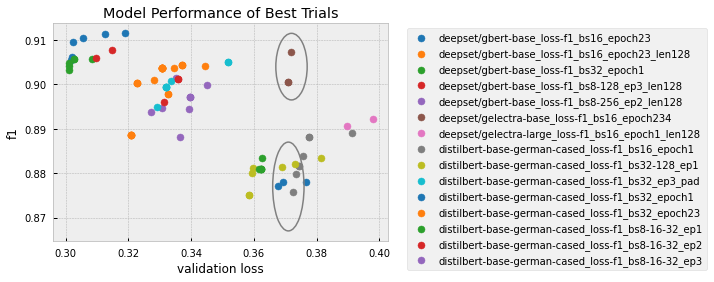

In [18]:
from matplotlib.patches import Ellipse
import seaborn as sns
pal = sns.color_palette("tab10", 10)

plt.style.use('bmh')

for i, s in enumerate(sorted(best_trials_df.study_name.unique())):
    df = best_trials_df[lambda x: x["study_name"] == s]
    plt.scatter(df.eval_loss, df.eval_f1, label=s, color=pal[i%10])


ax = plt.gca()
ax.add_patch(Ellipse(xy=(0.371, 0.877), width=0.01, height=0.02, edgecolor='gray', fc='None', lw=1.5))
ax.add_patch(Ellipse(xy=(0.372, 0.904), width=0.01, height=0.015, edgecolor='gray', fc='None', lw=1.5))

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel("validation loss")
plt.ylabel("f1")
plt.title("Model Performance of Best Trials");

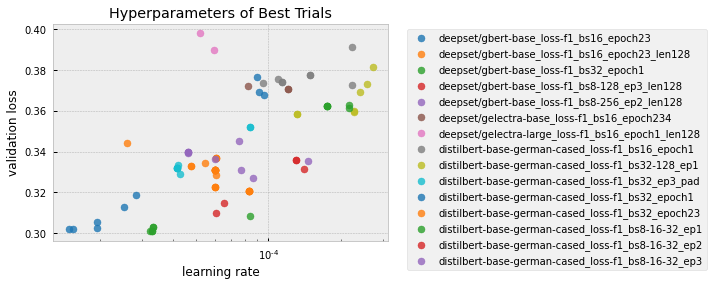

In [19]:
for i, s in enumerate(sorted(best_trials_df.study_name.unique())):
    df = best_trials_df[lambda x: x["study_name"] == s]
    plt.scatter(df.learning_rate, df.eval_loss, label=s, color=pal[i%10], alpha=0.8)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xscale("log")
plt.xlabel("learning rate")
plt.ylabel("validation loss")
plt.title("Hyperparameters of Best Trials");

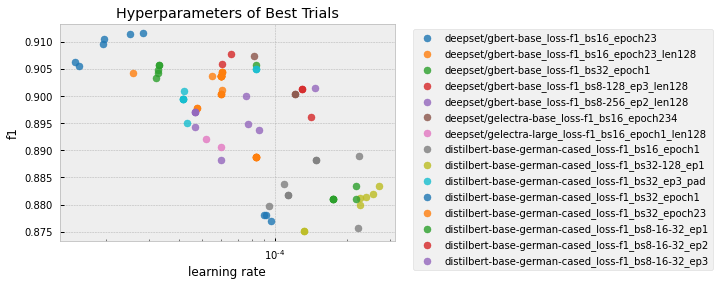

In [20]:
for i, s in enumerate(sorted(best_trials_df.study_name.unique())):
    df = best_trials_df[lambda x: x["study_name"] == s]
    plt.scatter(df.learning_rate, df.eval_f1, label=s, color=pal[i%10], alpha=0.8)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xscale("log")
plt.xlabel("learning rate")
plt.ylabel("f1")
plt.title("Hyperparameters of Best Trials");

In [21]:
# optuna.delete_study('distilbert-base-german-cased_multi_mcc', storage)
[s.study_name for s in optuna.get_all_study_summaries(storage)]

['deepset/gelectra-base_loss-f1_bs16_epoch234',
 'distilbert-base-german-cased_loss-f1_bs32_epoch23',
 'distilbert-base-german-cased_loss-f1_bs32_epoch1',
 'deepset/gbert-base_loss-f1_bs32_epoch1',
 'deepset/gbert-base_loss-f1_bs16_epoch23',
 'deepset/gbert-base_loss-f1_bs16_epoch23_len128',
 'deepset/gelectra-large_loss-f1_bs16_epoch1_len128',
 'distilbert-base-german-cased_loss-f1_bs16_epoch1',
 'distilbert-base-german-cased_loss-f1_bs8-16-32_ep1',
 'distilbert-base-german-cased_loss-f1_bs8-16-32_ep2',
 'distilbert-base-german-cased_loss-f1_bs8-16-32_ep3',
 'distilbert-base-german-cased_loss-f1_bs32-128_ep1',
 'distilbert-base-german-cased_loss-f1_bs32_ep3_pad',
 'deepset/gbert-base_loss-f1_bs8-128_ep3_len128',
 'deepset/gbert-base_loss-f1_bs8-256_ep2_len128']

## Load Study

In [22]:
# study = optuna.load_study('deepset/gbert-base_bs16_epoch234', storage)
# study = optuna.load_study('deepset/gelectra-base_loss-f1_bs16_epoch234', storage)
# study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs32_epoch1', storage)
# study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs16_epoch1', storage)
# study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs32_epoch23', storage)
# study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs8-16-32_ep1', storage)
# study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs32-128_ep1', storage)
# study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs32_ep3_pad', storage)
# study = optuna.load_study('deepset/gbert-base_loss-f1_bs32_epoch1', storage)
# study = optuna.load_study('deepset/gbert-base_loss-f1_bs16_epoch23', storage)
# study = optuna.load_study('deepset/gbert-base_loss-f1_bs16_epoch23_len128', storage)
study = optuna.load_study('deepset/gbert-base_loss-f1_bs8-128_ep3_len128', storage)
# study = optuna.load_study('deepset/gelectra-large_loss-f1_bs16_epoch1_len128', storage)

## Hyperparameter Overview

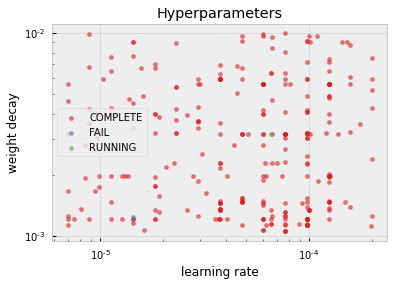

In [23]:
from optuna.trial import TrialState

params = []
for t in study.get_trials(deepcopy=False):
    params.append({"state": str(t.state).split('.')[1], **t.params})
state_params_df = pd.DataFrame(params)

pal = sns.color_palette("Set1")

field="state"
for i, f in enumerate(sorted(state_params_df[field].unique())):
    df = state_params_df[lambda x: x[field] == f]
    plt.scatter(df.learning_rate, df.weight_decay, alpha=0.6, s=16, label=f, color=pal[i])
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.title("Hyperparameters")
plt.xlabel("learning rate")
plt.ylabel("weight decay");

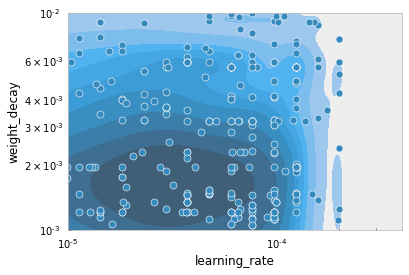

In [24]:
param_df = pd.DataFrame([t.params for t in study.get_trials(deepcopy=False)])
g = sns.kdeplot(x=param_df.learning_rate, y=param_df.weight_decay, shade=True)
g = sns.scatterplot(x=param_df.learning_rate, y=param_df.weight_decay)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlim((1e-5, 4e-4))
plt.ylim((1e-3, 1e-2));

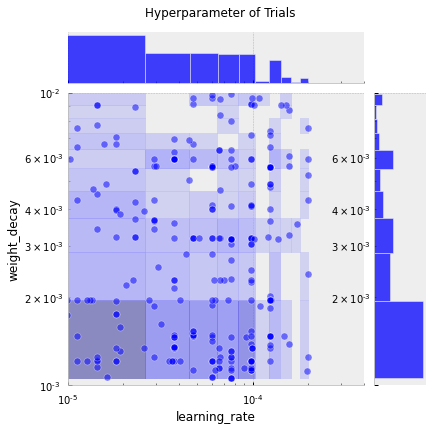

In [25]:
g = sns.jointplot(x=param_df.learning_rate, y=param_df.weight_decay, kind='hist', xlim=(1e-5, 4e-4), ylim=(1e-3, 1e-2), color="b")
g.plot_joint(sns.scatterplot, color="b", zorder=1, alpha=0.5)
g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')
# g.fig.tight_layout()
g.ax_joint.collections[0].set_alpha(0.6) # tile alpha
g.fig.suptitle("Hyperparameter of Trials")
g.fig.subplots_adjust(top=0.92)
plt.xlabel("learning rate")
plt.ylabel("weight decay");

## Analyze Zombie Trials

Interupted trials left in RUNNING state.

In [26]:
from optuna.trial import TrialState

running_trials = study.get_trials(states=[TrialState.RUNNING])

pd.DataFrame([t.params for t in running_trials])

,learning_rate,num_train_epochs,per_device_train_batch_size,weight_decay
0,0.000065,3,16,0.003177


## Analyze Complete Trials

In [27]:
from optuna.trial import TrialState

complete_trials = study.get_trials(states=[TrialState.COMPLETE])

def get_metrics(trial):
    attrs = trial.user_attrs
    if "eval_result" in attrs.keys():
        attrs = attrs["eval_result"]
    return attrs

# compile trial details for further analysis
if len(complete_trials) > 0:
    index = [t.number for t in complete_trials]
    trial_metrics_df = pd.DataFrame([get_metrics(t) for t in complete_trials], index=index)
    trial_params_df = pd.DataFrame([t.params for t in complete_trials], index=index)
    trial_df = pd.concat([trial_params_df, trial_metrics_df], axis=1).sort_values("eval_loss", ascending=True)
    best = [t.number for t in study.best_trials]
    trial_df["best"] = trial_df.index.isin(best)
    main_metric = "eval_loss"
    trial_params_df[main_metric] = trial_metrics_df[main_metric]
    display(trial_df.head(10))
else:
    raise ValueError("there must be at least one complete trial")

,learning_rate,num_train_epochs,per_device_train_batch_size,weight_decay,eval_loss,eval_acc,eval_f1,eval_precision,eval_recall,eval_mcc,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,best
54,0.000060,3,64,0.001069,0.309711,0.909533,0.905857,0.905773,0.906911,0.896490,5.1346,200.212,25.124,3.0,True
274,0.000060,3,64,0.001959,0.310844,0.905642,0.902247,0.901388,0.904139,0.892058,4.9149,209.158,26.246,3.0,False
218,0.000060,3,64,0.005594,0.312473,0.906615,0.903254,0.902646,0.904547,0.893102,4.9511,207.633,26.055,3.0,False
264,0.000065,3,64,0.001339,0.314870,0.910506,0.907684,0.906755,0.909598,0.897623,4.9542,207.503,26.039,3.0,True
183,0.000065,3,64,0.001145,0.314870,0.910506,0.907684,0.906755,0.909598,0.897623,4.9042,209.616,26.304,3.0,False
141,0.000077,3,64,0.001246,0.315081,0.901751,0.897011,0.897391,0.898469,0.887548,4.9630,207.134,25.993,3.0,False
245,0.000065,3,64,0.006376,0.316040,0.907588,0.904448,0.905446,0.904003,0.894148,5.0472,203.675,25.558,3.0,False
267,0.000065,3,64,0.006376,0.316040,0.907588,0.904448,0.905446,0.904003,0.894148,4.9634,207.116,25.990,3.0,False
275,0.000060,3,64,0.003177,0.316852,0.905642,0.902274,0.901423,0.904340,0.892089,4.9076,209.470,26.286,3.0,False
277,0.000081,3,64,0.005621,0.317236,0.902724,0.899397,0.899636,0.900329,0.888616,4.9283,208.593,26.176,3.0,False


In [28]:
import plotly.express as px

fig = px.parallel_coordinates(trial_df[trial_params_df.columns], color=main_metric, 
                             color_continuous_scale=px.colors.sequential.Oryel)
fig.update_layout(autosize=False, width=700, height=350)
fig.show()

In [29]:
# fig = optuna.visualization.plot_parallel_coordinate(study, target=lambda trial: trial.user_attrs["eval_loss"], target_name="loss")
# fig.update_layout(autosize=False, width=700, height=350)
# fig.show()

In [30]:
# optuna.visualization.plot_contour(study)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



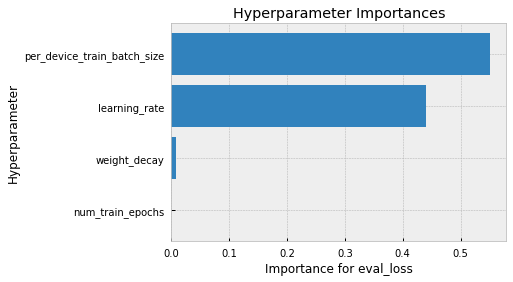

In [31]:
# from optuna.visualization import plot_param_importances
from optuna.visualization.matplotlib import plot_param_importances

fig = plot_param_importances(
    study, target=lambda t: t.values[0], target_name="eval_loss"
)
# fig.update_layout(autosize=False, width=800, height=350)
# fig.show()

In [32]:
def get_loss(trial):
    """Handle different data format versions"""
    if "eval_result" in trial.user_attrs.keys():
        return trial.user_attrs["eval_result"]["eval_loss"]
    else:
        return trial.user_attrs["eval_loss"]

In [33]:
fig = optuna.visualization.plot_slice(study, target=get_loss, target_name="loss")
fig.update_layout(autosize=False, width=900, height=350)
fig.show()

## Single Trial - Extract data logged during train

In [34]:
running_trials = [t for t in study.get_trials() if t.state==TrialState.RUNNING]
data = complete_trials[-1].user_attrs
if "eval_result" in data.keys():
    log_df = pd.DataFrame(data.values(), index=data.keys())[lambda x: x.index != "eval_result"]
    log_df.index = log_df.index.astype(int)
    log_df.sort_index(inplace=True)
    display(log_df)

,eval_loss,eval_acc,eval_f1,eval_precision,eval_recall,eval_mcc,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,lr
28,0.573222,0.827821,0.819543,0.845398,0.812519,0.805790,4.9613,207.205,26.001,0.19,0.000091
56,0.439471,0.859922,0.857084,0.862250,0.859070,0.841123,4.9234,208.799,26.201,0.39,0.000085
84,0.390443,0.875486,0.869493,0.870234,0.872798,0.857740,4.9188,208.994,26.226,0.58,0.000079
112,0.422539,0.863813,0.859187,0.866539,0.860881,0.845358,4.9324,208.418,26.154,0.78,0.000072
140,0.409612,0.874514,0.869307,0.868860,0.872499,0.856541,4.9166,209.088,26.238,0.97,0.000066
168,0.365343,0.881323,0.877870,0.878848,0.878975,0.864374,4.9047,209.594,26.301,1.17,0.000060
196,0.365726,0.888132,0.883512,0.880936,0.886854,0.872063,4.9204,208.927,26.217,1.36,0.000053
224,0.382641,0.886187,0.882604,0.880584,0.886990,0.869966,4.9324,208.416,26.153,1.55,0.000047
252,0.329445,0.903696,0.901101,0.904652,0.899415,0.889775,4.9184,209.012,26.228,1.75,0.000041
280,0.336241,0.903696,0.898058,0.899172,0.898490,0.889880,4.9425,207.991,26.100,1.94,0.000034


NameError: ignored

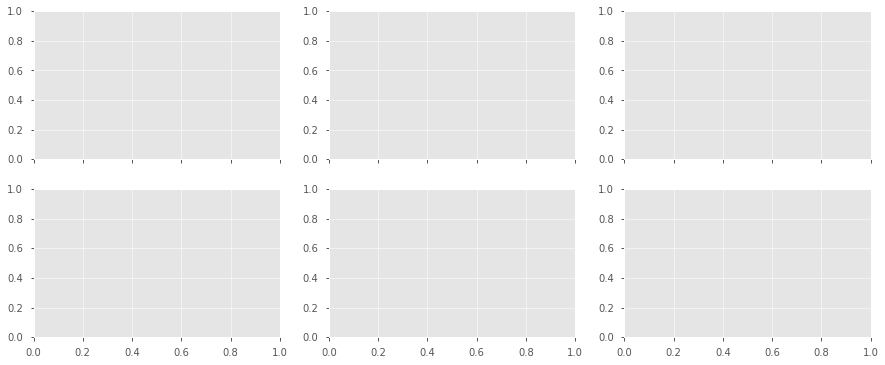

In [35]:
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True)

for col, ax in zip(metrics, axs.flatten()):
    log_df[col][0:-1].plot(ax=ax).axhline(log_df[col].values[-1], c="grey", linestyle=":")
    ax.set_title(col)
    ax.set_xlabel("step")
    # ax.grid(axis='y', linestyle='--', zorder=1)
    # ax.grid(axis='x', linestyle=':', zorder=1)

plt.tight_layout()

## Plot Learning Rate

In [ ]:
log_df["lr"].plot()
plt.scatter(log_df["lr"].index, log_df["lr"]);